In [1]:
from shapely.geometry import Point
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import requests

In [2]:
variables= {'race': ['total_race', 'white_alone', 'black_alone'],
           'household_inc': ['total_household_inc', '<10k', '10-14.9k', '15-19.9k', '20-24.9k', '25-29.9k', '30-34.9k', '35-39.9k', '40-44.9k', '45-49.9k', '50-59.9k', '60-74.9k', '75-99.9k', '100-124.9k', '125-149.9k', '150-199.9k', '200k+'],
           'household_type': ['total_household_type', 'household_type_family_household', 'household_type_nonfamily_household']}

In [3]:
# import data and get tables to have the same columns for merging
# vacant table cleaning
vacant_data = pd.read_csv('data/vacant_abandonded.csv')
vacant_data.columns = [c.lower().replace(' ', '_') for c in vacant_data.columns]
vacant_data['street_address'] = vacant_data['address_street_number'].map(str) + " " + vacant_data['address_street_direction'] + " " + vacant_data['address_street_name'] + " " + vacant_data['address_street_suffix']
vacant_data = vacant_data.drop(columns=['location_of_building_on_the_lot_(if_garage,_change_type_code_to_bgd).', 
	'is_the_building_dangerous_or_hazardous?', 'is_building_open_or_boarded?', 'if_the_building_is_open,_where_is_the_entry_point?', 
	'is_the_building_currently_vacant_or_occupied?', 'is_the_building_vacant_due_to_fire?', 'address_street_number', 'address_street_direction', 'address_street_name', 'address_street_suffix'])
vacant_data = vacant_data.rename(index=str, columns={'any_people_using_property?_(homeless,_childen,_gangs)':'subtype', 
	'date_service_request_was_received':'creation_date', 'service_request_type':'type_of_service_request'})
vacant_data = vacant_data.replace({"subtype":{True:"vacant"}})
vacant_data = vacant_data.replace({"subtype":{False:"filled"}})
vacant_data["completion_date"] = np.nan
vacant_data["status"] = np.nan

In [4]:
# alley table cleaning
alley_data = pd.read_csv('data/alley.csv')
alley_data.columns = [c.lower().replace(' ', '_') for c in alley_data.columns]
alley_data["subtype"] = np.nan

In [5]:
# graffiti table cleaning
graffiti_data = pd.read_csv('data/graffiti.csv')
graffiti_data.columns = [c.lower().replace(' ', '_') for c in graffiti_data.columns]
graffiti_data = graffiti_data.rename(index=str, columns={'what_type_of_surface_is_the_graffiti_on?':'subtype'})
graffiti_data = graffiti_data.drop(columns=['ssa','where_is_the_graffiti_located?'])

In [6]:
# merge data and filter for 2017 data only
vacant_plus_alley = pd.concat([vacant_data, alley_data])
all_data = pd.concat([vacant_plus_alley, graffiti_data])
all_data_2017 = all_data[all_data['creation_date'].str.contains('2017')]

# fill nas with integers
fillna = ['zip_code', 'ward', 'police_district', 'community_area']
for x in fillna:
    all_data_2017.loc[:,[x]] = all_data_2017.loc[:,[x]].fillna(0).astype(int)

#all_data_2017.head()
#all_data_2017.to_csv('all_data_2017.csv')

C:\Users\Alix Gates\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
# problem 1.2: summary statistics
# request of each type (buildings, alley, graffiti) broken down by:
    # month
    # neighborhood by:
        # zip code
        # police district
    # response time by ciy where possible

In [8]:
# re-format date columns
date_columns = ['creation_date', 'completion_date']
for x in date_columns:
    all_data_2017[x] = pd.to_datetime(all_data_2017[x],format='%m/%d/%Y')

all_data_2017.index = all_data_2017['creation_date']

# how many requests for each type by month
group_time = all_data_2017.groupby([all_data_2017.index.month, 'type_of_service_request'])
group_time = group_time['type_of_service_request'].count().unstack()
group_time.style

C:\Users\Alix Gates\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


type_of_service_request,Alley Light Out,Graffiti Removal,Vacant/Abandoned Building
creation_date,,,
1,2606,9025,232
2,2552,9282,369
3,2454,8682,378
4,2189,8708,382
5,2272,8871,400
6,2402,7677,291
7,1867,7132,324
8,2029,10296,350
9,1816,11888,264


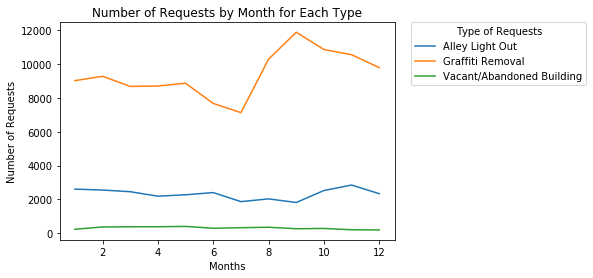

In [9]:
group_time.plot(title = "Number of Requests by Month for Each Type")
plt.xlabel("Months")
plt.ylabel("Number of Requests")
plt.legend(title = "Type of Requests", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [10]:
# number of requests for each type by zip code
group_zipcode = all_data_2017.groupby(['zip_code', 'type_of_service_request'])
group_zipcode = group_zipcode['zip_code'].count().unstack()
group_zipcode.style

type_of_service_request,Alley Light Out,Graffiti Removal,Vacant/Abandoned Building
zip_code,,,
0,35,59,31
60601,1,807,nan
60602,nan,193,nan
60603,3,152,nan
60604,1,92,nan
60605,6,795,nan
60606,nan,431,nan
60607,83,1184,4
60608,708,9779,42


In [11]:
# number of requests for each type by police district
group_policedist = all_data_2017.groupby(['police_district', 'type_of_service_request'])
group_policedist = group_policedist['police_district'].count().unstack()
group_policedist.style

type_of_service_request,Alley Light Out,Graffiti Removal,Vacant/Abandoned Building
police_district,,,
0,16,42,5
1,24,3135,1
2,472,574,75
3,821,214,253
4,2287,1776,445
5,1449,312,449
6,1470,305,404
7,807,562,652
8,4917,13992,149


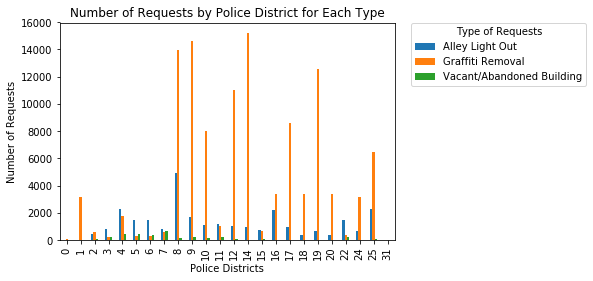

In [12]:
group_policedist.plot.bar(title = "Number of Requests by Police District for Each Type")
plt.xlabel("Police Districts")
plt.ylabel("Number of Requests")
plt.legend(title = "Type of Requests", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [13]:
# request of subtypes for buildings and graffiti broken down by:
    # month
    # neighborhood by:
        # zip code
        # police district
    # response time by ciy where possible

In [14]:
group_time = all_data_2017.groupby(by=[all_data_2017.index.month, 'subtype', 'type_of_service_request'])
group_time = group_time['subtype'].count().unstack()
group_time.style

In [15]:
group_subtype_zipcode = all_data_2017.groupby(['zip_code', 'subtype', 'type_of_service_request',])
group_subtype_zipcode = group_subtype_zipcode['subtype'].count().unstack()
group_subtype_zipcode.style

In [16]:
group_subtype_policedist = all_data_2017.groupby(['police_district', 'subtype', 'type_of_service_request'])
group_subtype_policedist = group_subtype_policedist['subtype'].count().unstack()
group_subtype_policedist.style

In [17]:
# problem 1.3: 5 things I learned
    # 1. The barchart for counts of each service type by police district shows that different types of crime occur 
        # in different neighborhoods. When the relative count of Graffiti Removal spikes, but the counts for Alley Lights 
        # Out and Vacant/Abandonded do not.
    # 2. The line graph shows that requests for all three types decrease in December and pick up after the new year. 
        # Also, that graffiti removal requests spike when the weather is nicer, with the largest spike in September. 
        # Alley light requests are increased in winter, and are highest in November, around the time clocks are changed 
        # for daylights saving putting more people are out after dark.
    # 3. The barchart for counts of each service type by police district shows that police districts in the south and west sides 
        # (4, 5, 6, 7, 8) are more likely to have reports of vacant buildings, whereas reports for Alley Light Out and Graffiti 
        # Removal are some in the west (specifically district 8 has a high reporting for Graffiti Removal), but mostly in the 
        # north side.
    # 4. The most common subtype for Graffiti Removal requests is metal-painted.
    # 5. If an building is reported vacant/abandonded, it is more likely to be reported as filled than vacant.

In [18]:
# problem 2
# pull data from ACS API for race (race total, white alone, black alone, hispanic total, income, family size...
acs_data = pd.read_json("https://api.census.gov/data/2016/acs/acs5?get=B02001_001E,B02001_002E,B02001_003E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B19001_014E,B19001_015E,B19001_016E,B19001_017E,B11016_001E,B11016_002E,B11016_009E&for=block+group:*&in=state:17+county:031+tract:*&key=17c33afc69e74a76256559f11768a4005763e816")
col_names=["total_race", "white_alone", "black_alone", "total_household_inc", "<10k", "10-14.9k", "15-19.9k", "20-24.9k", "25-29.9k", "30-34.9k", "35-39.9k", "40-44.9k", "45-49.9k", "50-59.9k", "60-74.9k", "75-99.9k", "100-124.9k", "125-149.9k", "150-199.9k", "200k+", "total_household_type", "household_type_family_household", "household_type_nonfamily_household","state","county","tract","block_group"]
acs_data.columns = col_names
acs_data["GEOID"] = acs_data["state"] + acs_data["county"] + acs_data["tract"] + acs_data["block_group"]
acs_data = acs_data.drop([0])

variables= {'race': ['total_race', 'white_alone', 'black_alone'],
           'household_inc': ['total_household_inc', '<10k', '10-14.9k', '15-19.9k', '20-24.9k', '25-29.9k', '30-34.9k', '35-39.9k', '40-44.9k', '45-49.9k', '50-59.9k', '60-74.9k', '75-99.9k', '100-124.9k', '125-149.9k', '150-199.9k', '200k+'],
           'household_type': ['total_household_type', 'household_type_family_household', 'household_type_nonfamily_household']}

dict_of_new_names = {}
def find_percents(variables, dataframe):
    #print(dict_of_new_names)
    for category in variables.keys():
        col_names = []
        denominator = variables[category][0]
        denom_data = pd.to_numeric(dataframe[denominator])
        for variable in variables[category][1:]:
            new_col_name = 'percent_' + variable
            numer_data = pd.to_numeric(dataframe[variable])
            dataframe[new_col_name] = numer_data/denom_data
            col_names.append(new_col_name)
        dict_of_new_names[category] = col_names
    return dataframe, dict_of_new_names

find_percents(variables, acs_data)
print(list(acs_data))
#print(dict_of_new_names)

['total_race', 'white_alone', 'black_alone', 'total_household_inc', '<10k', '10-14.9k', '15-19.9k', '20-24.9k', '25-29.9k', '30-34.9k', '35-39.9k', '40-44.9k', '45-49.9k', '50-59.9k', '60-74.9k', '75-99.9k', '100-124.9k', '125-149.9k', '150-199.9k', '200k+', 'total_household_type', 'household_type_family_household', 'household_type_nonfamily_household', 'state', 'county', 'tract', 'block_group', 'GEOID', 'percent_white_alone', 'percent_black_alone', 'percent_<10k', 'percent_10-14.9k', 'percent_15-19.9k', 'percent_20-24.9k', 'percent_25-29.9k', 'percent_30-34.9k', 'percent_35-39.9k', 'percent_40-44.9k', 'percent_45-49.9k', 'percent_50-59.9k', 'percent_60-74.9k', 'percent_75-99.9k', 'percent_100-124.9k', 'percent_125-149.9k', 'percent_150-199.9k', 'percent_200k+', 'percent_household_type_family_household', 'percent_household_type_nonfamily_household']


In [19]:
#exclude = ['state', 'county', 'tract', 'block_group']
#race = ['total_race', 'white_alone', 'black_alone']
#ethnic = ['total_ethnic', 'non_hisp', 'hisp', 'mexican', 'puerto_rican']
#household_inc = ['total_household_inc', '<10k', '10-14.9k', '15-19.9k', '20-24.9k', '25-29.9k', '30-34.9k', '35-39.9k', '40-44.9k', '45-49.9k', '50-59.9k', '60-74.9k', '75-99.9k', '100-124.9k', '125-149.9k', '150-199.9k', '200k+']
#household_type = ['total_household_type', 'household_type_family_household', 'household_type_nonfamily_household']
#lists = [race, ethnic, household_inc, household_type]

# UNFINISHED!
def variable_names (col_names):
    '''
    based on the new column names, make variable names that can be used for later analysis.
    input: col_names
    output: dictionary with keys as the category and value as a list of the 
    '''
    categories = []
    variables = []
    
    for counter, variable in enumerate(col_names):
        #print(counter, variable)
        if variable.startswith("total_"):
            categories.append(variable.lstrip('total_'))
            variable 
            variables.append(counter+1
            #print(categories)
    return categories, variables
        #else:
            

variable_names(col_names)

'\n    based on the new column names, make variable names that can be used for later analysis.\n    input: col_names\n    2 outputs: 1. list of lists with specific types of variables grouped (example: all race variables together)\n               2. names for those groupings\n    \n    categories = []\n    variables = []\n    \n    for counter, variable in enumerate(col_names):\n        #print(counter, variable)\n        if variable.startswith("total_"):\n            categories.append(variable.lstrip(\'total_\'))\n            variable \n            variables.append(counter+1\n            #print(categories)\n    return categories, variables\n        #else:\n            \n\nvariable_names(col_names)\n                             '

In [20]:
# grab block group TIGER shapefile from census and merge with ACS data on ID
shp_data = gpd.read_file("tiger_files/")
acs_with_shp = pd.merge(acs_data, shp_data, on="GEOID")

In [21]:
# use geopandas spatial join to map lat-longs from chicago open data to polygons for block groups from the shapefile
all_data_2017 = all_data_2017.dropna(subset=['latitude','longitude']) 
geometry = [Point(xy) for xy in zip(all_data_2017.longitude, all_data_2017.latitude)]
all_data_2017_geo = all_data_2017.drop(['longitude', 'latitude'], axis=1)
all_data_geo = gpd.GeoDataFrame(all_data_2017_geo, geometry=geometry)
acs_with_shp_geo = gpd.GeoDataFrame(acs_with_shp)
acs_311_shp = gpd.sjoin(all_data_geo, acs_with_shp_geo)
acs_311_shp.head()

,community_area,completion_date,creation_date,location,police_district,service_request_number,status,street_address,subtype,type_of_service_request,...,COUNTYFP,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
2017-01-03,27,NaT,2017-01-03,"(41.88286068279902, -87.6998616079848)",12,17-00042635,NaN,2943.0 W WASHINGTON BLVD,filled,Vacant/Abandoned Building,...,031,837000,2,Block Group 2,G5030,S,165316,0,+41.8810498,-087.6987461
2017-01-20,27,NaT,2017-01-20,"(41.8819590621502, -87.69963918510999)",12,17-00365241,NaN,2935.0 W WARREN BLVD,vacant,Vacant/Abandoned Building,...,031,837000,2,Block Group 2,G5030,S,165316,0,+41.8810498,-087.6987461
2017-01-20,27,NaT,2017-01-20,"(41.88197922138148, -87.69772540216383)",12,17-00353763,NaN,2857.0 W WARREN BLVD,vacant,Vacant/Abandoned Building,...,031,837000,2,Block Group 2,G5030,S,165316,0,+41.8810498,-087.6987461
2017-04-17,27,NaT,2017-04-17,"(41.88286301634214, -87.69963794482824)",12,17-02274448,NaN,2934.0 W WASHINGTON BLVD,NaN,Vacant/Abandoned Building,...,031,837000,2,Block Group 2,G5030,S,165316,0,+41.8810498,-087.6987461
2017-03-18,27,NaT,2017-03-18,"(41.879213710153714, -87.69988780690524)",11,17-01474215,NaN,2948.0 W WILCOX ST,vacant,Vacant/Abandoned Building,...,031,837000,2,Block Group 2,G5030,S,165316,0,+41.8810498,-087.6987461


In [22]:
#acs_311_shp_buildings = acs_311_shp.loc[acs_311_shp['type_of_service_request'] == 'Vacant/Abandoned Building']
#acs_311_shp_buildings.isnull().any()

In [32]:
# problem 2.a What types of blocks get “Vacant and Abandoned Buildings Reported”?

# The analysis looked at the race, ethnicitiy, household income and household type for blocks that 
# reported vacant and abandonded building. 

# Race: There is a very clear divide. The average percent of white residents living on a block that 
# reported a vacant or abandonded building was 11.6%, compared to an average of 80.5% black residents.

# Ethnicity: While I expected there to be a difference among hispanic and non-hispanic, and was interested in differences
# between Puerto Rican and Mexican neighborhoods around Chicago, this data did not yeild any results.

# Household Income: This variable shows that blocks with the lowest income populations see more reporting of vacant and 
# abandoned buildings. Speicifically, the share of blocks reported that had incomes below $10,000 a year was 
# almost 17%. Overall, th average percent of blocks reporting vacant or abandonded buildings decreased as the income increased,
# however, the average increases, compared to the incomes immediately below and above this range, for incomes betweem 
# $50,000 and $100,000. The average then decreases again.

# Household Type: Here there is also a difference between family household types and non-family household types. Family household
# types see an average of 63%, whereas non-family household types see an average of 36%. 

# code to answer above question: filter by Vacant and Abandoned Buildings Reported and run basic stats

acs_311_shp_buildings = acs_311_shp.loc[acs_311_shp['type_of_service_request'] == 'Vacant/Abandoned Building']

def basic_stats (variables, dataframe, request_type):
    '''
    a function to create the basic stats tables for each category.
    inputs:
        variables: a dictionary that maps catetories to the variables that are associated with it
        dataframe: the dataframe where the data to be described lives
        request_type: 
    '''
    #print(lists)
    columns = ["empty"]
    for category in variables.keys():
        #print(topic)
        df = "df_" + category + "_" + request_type
        df = pd.DataFrame(columns=columns)
        df = df.fillna(0)
        #print(df)
        for var in variables[category]:
            #print(dataframe[var], "var")
            df_to_add = dataframe[var].describe()
            #df_to_add = dataframe[var].pivot_table(columns="block_group")
            #print(df_to_add)
            df = pd.concat([df, df_to_add], axis=1)
        print("this is for", category, "category:", df)
        #print("this is for", x, "variable:", group_acs_311_shp_buildings)
    
basic_stats(dict_of_new_names, acs_311_shp_buildings, "buildings")

this is for race category:       empty  percent_white_alone  percent_black_alone
25%     NaN             0.000000             0.818182
50%     NaN             0.013109             0.961318
75%     NaN             0.082225             0.986784
count   NaN          3664.000000          3664.000000
max     NaN             1.000000             1.000000
mean    NaN             0.116517             0.804820
min     NaN             0.000000             0.000000
std     NaN             0.224417             0.316131
this is for household_inc category:       empty  percent_<10k  percent_10-14.9k  percent_15-19.9k  \
25%     NaN      0.086639          0.034314          0.038375   
50%     NaN      0.155378          0.083333          0.080200   
75%     NaN      0.226171          0.128492          0.121756   
count   NaN   3664.000000       3664.000000       3664.000000   
max     NaN      0.625641          0.406375          0.354839   
mean    NaN      0.168665          0.089088          0.085724

In [33]:
# problem 2.b What types of blocks get “Alley Lights Out”?

# The analysis looked at the race, ethnicitiy, household income and household type for blocks that 
# reported alley lights out.

# Race: There is not a very clear divide. The average percent of white residents living on a block that 
# reported an out alley light was nearly identical to the average seen for black residents: 40%.

# Ethnicity: While I expected there to be a difference among hispanic and non-hispanic, and was interested in differences
# between Puerto Rican and Mexican neighborhoods around Chicago, this data did not yeild any results.

# Household Income: This variable shows that blocks with the lowest income populations see more reporting of alley lights out. 
# Speicifically, the share of blocks reported that had incomes below $10,000 a year was almost 10%. Overall, the average 
# percent of blocks reporting alley lights out decreased as the income increased, however, the average increases, compared 
# to the incomes immediately below and above this range, for incomes betweem $50,000 and $100,000. 
# The average then decreases again.

# Household Type: Here there is also a difference between family household types and non-family household types. Family household
# types see an average of 65%, whereas non-family household types see an average of 35%. 

# problem 2.b - filter by alley lights out and run basic stats
acs_311_shp_alleys = acs_311_shp.loc[acs_311_shp['type_of_service_request'] == 'Alley Light Out']

basic_stats(dict_of_new_names, acs_311_shp_alleys, "alleys")


this is for race category:       empty  percent_white_alone  percent_black_alone
25%     NaN             0.024390             0.011066
50%     NaN             0.418969             0.119829
75%     NaN             0.710579             0.926537
count   NaN         27860.000000         27860.000000
max     NaN             1.000000             1.000000
mean    NaN             0.400886             0.403757
min     NaN             0.000000             0.000000
std     NaN             0.339791             0.429231
this is for household_inc category:       empty  percent_<10k  percent_10-14.9k  percent_15-19.9k  \
25%     NaN      0.028517          0.017563          0.020370   
50%     NaN      0.079909          0.049536          0.051724   
75%     NaN      0.155070          0.100000          0.095541   
count   NaN  27860.000000      27860.000000      27860.000000   
max     NaN      0.559045          0.376147          0.600000   
mean    NaN      0.103631          0.063437          0.064034

In [34]:
# problem 2.c does that change over time in the data you collected?

# The analysis looked specifically at the race and household income for blocks that reported vacant and abandonded building by month.

# Race: While the race data changes by month, there seems to be a pattern for white reporting, but not for black. 
# The average percent of white residents living on a block that reported a vacant or abandonded building increases during winter months,
# compared to summer months. However, this same trend does not seem to hold for blocks with more black residents.

# Household Income: The trends from before hold: blocks with the lowest income populations see more reporting of vacant and 
# abandoned buildings. Speicifically, the share of blocks reported that had incomes below $10,000 a year was 
# fluctuates around 16%. Overall, the average percent of blocks reporting vacant or abandonded buildings decreased as the income increased.

# The analysis looked at the race and household income for blocks reporting alley lights out.

# Race: There is not a very clear divide. The average percent of white residents living on a block that 
# reported an out alley light was nearly identical to the average seen for black residents: 40%. That said, for white, the reporting
# is done mostly in the winter, whereas for black the reporting is done mostly in the summer.

# Household Income: This variable shows that blocks with the lowest income populations see more reporting of alley lights out. 
# Speicifically, the share of blocks reported that had incomes below $10,000 a year was almost 10%, with a generally higher average in the summer.
# Overall, the average percent of blocks reporting alley lights out decreased as the income increased.

# code for problem 2.c - filter by month for stand out variables above
acs_311_shp_buildings['creation_date'] = pd.to_datetime(acs_311_shp_buildings['creation_date'],format='%m/%d/%Y')
acs_311_shp_buildings['completion_date'] = pd.to_datetime(acs_311_shp_buildings['completion_date'],format='%m/%d/%Y')
acs_311_shp_buildings.index = acs_311_shp_buildings['creation_date']

group_acs_311_shp_buildings = acs_311_shp_buildings.groupby([acs_311_shp_buildings.index.month, 'type_of_service_request'])
basic_stats(dict_of_new_names, group_acs_311_shp_buildings, "buildings_time")

acs_311_shp_alleys['creation_date'] = pd.to_datetime(acs_311_shp_alleys['creation_date'],format='%m/%d/%Y')
acs_311_shp_alleys['completion_date'] = pd.to_datetime(acs_311_shp_alleys['completion_date'],format='%m/%d/%Y')
acs_311_shp_alleys.index = acs_311_shp_alleys['creation_date']

group_acs_311_shp_alleys = acs_311_shp_alleys.groupby([acs_311_shp_alleys.index.month, 'type_of_service_request'])
basic_stats(dict_of_new_names, group_acs_311_shp_alleys, "alleys_time")

C:\Users\Alix Gates\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Alix Gates\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


this is for race category:                                         empty  count      mean       std  min  \
creation_date type_of_service_request                                           
1             Vacant/Abandoned Building   NaN  232.0  0.112528  0.220194  0.0   
2             Vacant/Abandoned Building   NaN  369.0  0.126283  0.243843  0.0   
3             Vacant/Abandoned Building   NaN  377.0  0.112009  0.215127  0.0   
4             Vacant/Abandoned Building   NaN  382.0  0.141127  0.241153  0.0   
5             Vacant/Abandoned Building   NaN  400.0  0.096393  0.211116  0.0   
6             Vacant/Abandoned Building   NaN  291.0  0.084824  0.184658  0.0   
7             Vacant/Abandoned Building   NaN  324.0  0.138919  0.248123  0.0   
8             Vacant/Abandoned Building   NaN  350.0  0.117067  0.230343  0.0   
9             Vacant/Abandoned Building   NaN  264.0  0.098844  0.202884  0.0   
10            Vacant/Abandoned Building   NaN  280.0  0.089031  0.205021  0.0   
1

C:\Users\Alix Gates\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Alix Gates\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


this is for race category:                                       empty   count      mean       std  min  \
creation_date type_of_service_request                                          
1             Alley Light Out           NaN  2604.0  0.437994  0.339112  0.0   
2             Alley Light Out           NaN  2552.0  0.426949  0.333875  0.0   
3             Alley Light Out           NaN  2451.0  0.388585  0.335273  0.0   
4             Alley Light Out           NaN  2189.0  0.397630  0.332198  0.0   
5             Alley Light Out           NaN  2270.0  0.371013  0.340488  0.0   
6             Alley Light Out           NaN  2400.0  0.363437  0.341225  0.0   
7             Alley Light Out           NaN  1865.0  0.377618  0.341165  0.0   
8             Alley Light Out           NaN  2025.0  0.379287  0.340228  0.0   
9             Alley Light Out           NaN  1815.0  0.409900  0.344330  0.0   
10            Alley Light Out           NaN  2518.0  0.406190  0.339436  0.0   
11           

In [26]:
# problem 2.d - What is the difference in blocks that get “Vacant and Abandoned Buildings Reported” vs “Alley Lights Out”?

# The biggest difference between the two is race. For Vacanat and Abandonded Buildings Reported, there is a very clear 
# difference in the types of blocks that are reporting. Namely, blocks reporting are overwhemlingly black.
# Whereas in the Alley Lights Out variable, the blocks reporting are generally similar. Household income and household 
# type were about the same for both variables.

In [27]:
# problem 3a: Of the three types of requests you have data for, which request type is the most likely given the 
# call came from 3600 W Roosevelt Ave? What are the probabilities for each type of request?

# the most likely request type for that address is graffiti. probability for buildings and alleys is 0%, because 
# no requests were made by that address. probability for graffiti is 1/112699.

# search for 3600 W. Roosevelt* in acs_311_shp, 
acs_311_shp_3600 = acs_311_shp[acs_311_shp['street_address'].str.contains('3600 W ROOSEVELT', na=False)]
print(acs_311_shp_3600)

# probability
group_type = acs_311_shp.groupby(['type_of_service_request']).count()

            community_area completion_date creation_date  \
2017-10-23              29      2017-10-23    2017-10-23   

                                           location  police_district  \
2017-10-23  (41.86639889180933, -87.71548367828538)               11   

           service_request_number     status       street_address  \
2017-10-23            17-07124022  Completed  3600 W ROOSEVELT RD   

                      subtype type_of_service_request      ...       COUNTYFP  \
2017-10-23  Metal - Unpainted        Graffiti Removal      ...            031   

            TRACTCE  BLKGRPCE       NAMELSAD  MTFCC  FUNCSTAT   ALAND AWATER  \
2017-10-23   843000         1  Block Group 1  G5030         S  487117      0   

               INTPTLAT      INTPTLON  
2017-10-23  +41.8681494  -087.7129516  

[1 rows x 75 columns]


In [28]:
# problem 3b: Let’s now assume that a call comes in about Graffiti Removal. Which is more likely – 
# that the call came from Garfield Park (community areas 26 and 27) or Uptown (community area 3?
# How much more or less likely is it to be from Garfield Park vs Uptown?

# It is more likely that the call came from Uptown than Garfield Park, with Uptown having 1853 calls for graffiti removal
# and Garfield Park having only 454.

acs_311_shp_graffiti = acs_311_shp.loc[acs_311_shp['type_of_service_request'] == 'Graffiti Removal']
acs_311_shp_graffiti.head()
group = acs_311_shp_graffiti.groupby(['community_area']).count()

uptown = group.loc[3, 'street_address']
print(uptown)

garfield1 = group.loc[26, 'street_address']
garfield2 = group.loc[27, 'street_address']
garfield = garfield1 + garfield2
print(garfield)

1853
454


In [29]:
# problem 3c:
# garfield park = (100/600) * (600/1000) = .1, or 10%
# uptown = (160/400) * (400*1000) = .16, or 16%.